<a href="https://colab.research.google.com/github/HarshithVijay/Projects/blob/main/Fire_Incident_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 10.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/Fire/Fire-Incidents.csv')
data.head()

,Area_of_Origin,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Ext_agent_app_or_defer_time,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,...,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time
0,Porch or Balcony,No business interruption,0,86,3000,0,2018-08-24T17:06:26,Confined to object of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system did not operate,...,-79.412479,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Fire with smoke showing only - including vehic...,2018-08-24T16:49:36,2018-08-24T16:54:09
1,Cooking Area or Kitchen,Undetermined,0,28,50000,28,2018-11-24T07:19:00,Confined to part of room/area of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system operated,...,-79.530419,Plastic,Extinguished by occupant,Under Investigation,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire extinguished prior to arrival,2018-11-24T07:09:12,2018-11-24T07:14:23
2,"Living Area (e.g. living, TV, recreation, etc)",Not applicable (not a business),1,16,1000000,130,2017-02-09T18:02:13,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,...,-79.373460,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Flames showing from small area (one storey or ...,2017-02-09T17:45:07,2017-02-09T17:48:49
3,Undetermined (formerly 98),May not resume operations,0,12,1000000,14,2012-10-30T00:52:04,Entire Structure,Undetermined,Fire alarm system operation undetermined,...,-79.393700,Undetermined (formerly 98),Extinguished by fire department,Undetermined,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,Flames showing from large area (more than one ...,2012-10-30T00:42:01,2012-10-30T00:44:58
4,"Sleeping Area or Bedroom (inc. patients room, ...",Not applicable (not a business),8,11,125000,2,2018-07-08T04:35:00,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,...,-79.511539,Bedding,Extinguished by fire department,Suspected Arson,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire with no evidence from street,2018-07-08T04:08:50,2018-07-08T04:13:54


In [4]:
# Step 1: Data Preprocessing
# Handle missing values
numeric_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = data.select_dtypes(include=[object]).columns

In [5]:
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

In [6]:
# Convert date columns to datetime
date_columns = ['Ext_agent_app_or_defer_time', 'TFS_Alarm_Time', 'TFS_Arrival_Time']
for column in date_columns:
    data[column] = pd.to_datetime(data[column], errors='coerce')

In [7]:
# Feature Engineering
data['Year'] = data['TFS_Alarm_Time'].dt.year
data['Month'] = data['TFS_Alarm_Time'].dt.month
data['DayOfWeek'] = data['TFS_Alarm_Time'].dt.dayofweek
data['Hour'] = data['TFS_Alarm_Time'].dt.hour

In [8]:
# One-hot encode categorical variables
data = pd.get_dummies(data, drop_first=True)

In [9]:
# Step 2: Post-Incident Analysis
# Select a subset of features for the correlation matrix
subset_features = ['Year', 'Month', 'DayOfWeek', 'Hour', 'Estimated_Dollar_Loss', 'Civilian_Casualties']
subset_data = data[subset_features]

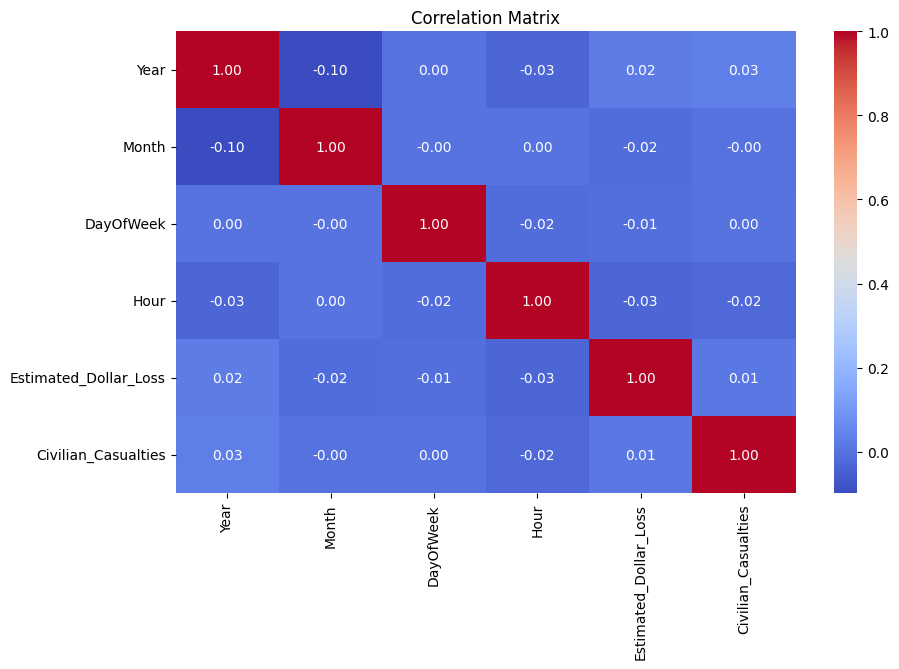

In [10]:
# Correlation Matrix
plt.figure(figsize=(10, 6))
correlation_matrix = subset_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [11]:
# Feature Importance using Random Forest
X = data.drop(['Civilian_Casualties'], axis=1)
y = data['Civilian_Casualties']

In [12]:
# Ensure only numeric columns are included for scaling
numeric_X = X.select_dtypes(include=[np.number])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(numeric_X, y, test_size=0.2, random_state=42)

In [ ]:
# Scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Random Forest Classifier with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


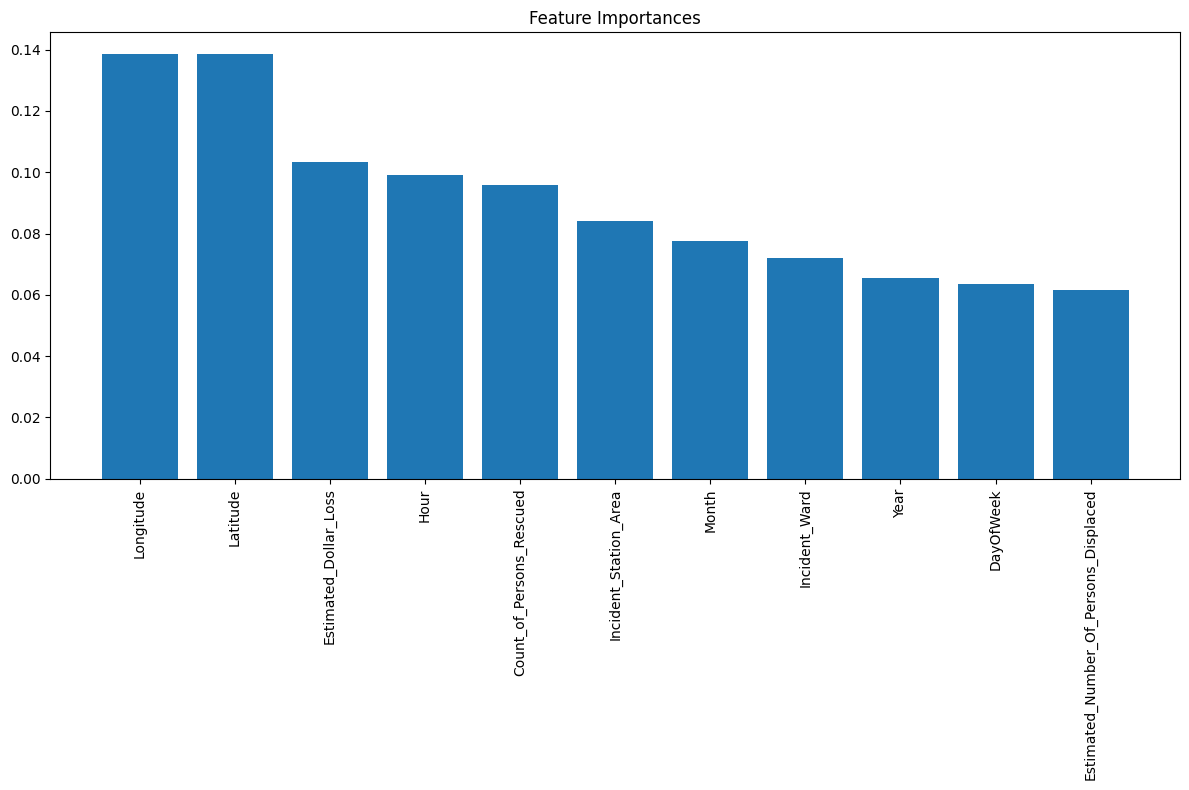

In [16]:
# Feature Importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(numeric_X.shape[1]), importances[indices], align='center')
plt.xticks(range(numeric_X.shape[1]), numeric_X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Step 3: Predictive Maintenance
# Predicting potential equipment failures
data['High_Dollar_Loss'] = data['Estimated_Dollar_Loss'] > data['Estimated_Dollar_Loss'].median()

In [18]:
# Update the features to include High_Dollar_Loss prediction
X = data.drop(['High_Dollar_Loss', 'Civilian_Casualties'], axis=1)
numeric_X = X.select_dtypes(include=[np.number])
y = data['High_Dollar_Loss']

In [19]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(numeric_X, y, test_size=0.2, random_state=42)

In [20]:
# Scaling the features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Random Forest Classifier
best_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [22]:
# Predictions
y_pred = best_rf.predict(X_test)

In [23]:
# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
print(f'ROC-AUC Score: {roc_auc}')

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1119
        True       1.00      1.00      1.00      1124

    accuracy                           1.00      2243
   macro avg       1.00      1.00      1.00      2243
weighted avg       1.00      1.00      1.00      2243

[[1119    0]
 [   0 1124]]
ROC-AUC Score: 1.0


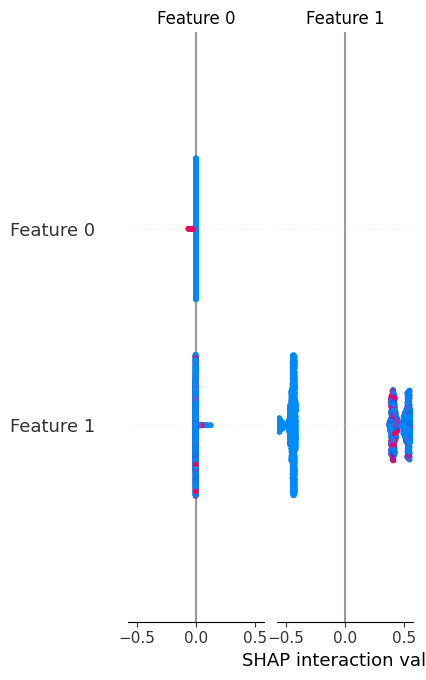

In [24]:
# SHAP for Feature Importance
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [25]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Cross-Validation ROC-AUC Scores: {cv_scores}')
print(f'Mean ROC-AUC Score: {cv_scores.mean()}')

# Feature Importance Review
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
important_features = numeric_X.columns[indices]

print("Top 10 Important Features:")
for i in range(10):
    print(f"{important_features[i]}: {importances[indices[i]]:.4f}")


Cross-Validation ROC-AUC Scores: [1. 1. 1. 1. 1.]
Mean ROC-AUC Score: 1.0
Top 10 Important Features:
Estimated_Dollar_Loss: 0.8581
Estimated_Number_Of_Persons_Displaced: 0.1020
Latitude: 0.0093
Longitude: 0.0084
Hour: 0.0043
Incident_Ward: 0.0043
Incident_Station_Area: 0.0040
Year: 0.0030
Month: 0.0027
DayOfWeek: 0.0021
